In [2]:
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import lxml
import pandas as pd
from lxml import objectify, etree, html
import json
from pandas import read_csv
from itertools import combinations
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from gensim import corpora, models

# ClassWork

In [3]:
topics = ['politics', 'science', 'culture', 'economy']

In [4]:
topicsInd = {'politics' : 0, 'science' : 1, 'culture' : 2, 'economy' : 3}

**Use corpus which was collected and saved in last *HomeWork* **

Input collected texts:

In [5]:
xmlstr = open('initial_texts.xml', encoding='utf-8').read()

In [6]:
utf8_parser = etree.XMLParser(encoding='utf-8')
root = etree.fromstring(xmlstr.encode('utf-8'), parser=utf8_parser)

In [7]:
allText = ({})

for topic in root:       
    texts = []
    for text in topic:
        sentances = []
        for sent in text:
            sentances.append(sent.text)
        t = ' '.join(sentances)
        texts.append((text.attrib['Title'], t))
    allText[topic.attrib["TopicName"]] = texts

Dictionary with lemmas and their indexes:

In [8]:
dictionary = read_csv('dictionary.csv',';')
dictionary = pd.DataFrame(data=dictionary["Words"])

In [9]:
words = dictionary["Words"]
words = words.get_values()
words

array(['АСВ', 'АТФ', 'АФК', ..., 'ячейка', 'ящер', 'ящик'], dtype=object)

In [10]:
dictWordToIndex = {w: (list(words).index(w)) for w in words}
dictWordToIndex

{'АСВ': 0,
 'АТФ': 1,
 'АФК': 2,
 'БВМ': 3,
 'БДТ': 4,
 'БЗК': 5,
 'БКС': 6,
 'БТС': 7,
 'Вa1': 8,
 'ВБРР': 9,
 'ВВВ': 10,
 'ВРП': 11,
 'ВШЭ': 12,
 'Ва1': 13,
 'ГРЦ': 14,
 'ГТС': 15,
 'ДЗЗ': 16,
 'ДКП': 17,
 'ДНР': 18,
 'Духless': 19,
 'ЗСТ': 20,
 'ИМБП': 21,
 'КЖК': 22,
 'КМГ': 23,
 'КМГК': 24,
 'ЛНР': 25,
 'М1а1': 26,
 'МКМЦ': 27,
 'МЛМ': 28,
 'ММКФ': 29,
 'МРЦ': 30,
 'МСП': 31,
 'МТР': 32,
 'МФЦ': 33,
 'МХТ': 34,
 'Н2А': 35,
 'НДФЛ': 36,
 'НТС': 37,
 'ОЗК': 38,
 'ОФЗ': 39,
 'ПСБ': 40,
 'РБК': 41,
 'РКК': 42,
 'РКС': 43,
 'РМГ': 44,
 'РФК': 45,
 'Россия1': 46,
 'СНВ': 47,
 'СО2': 48,
 'СПГ': 49,
 'СПФС': 50,
 'СТГТ': 51,
 'ТВЗ': 52,
 'ТНС': 53,
 'ТПК': 54,
 'ТТП': 55,
 'ФНБ': 56,
 'ФНПР': 57,
 'ФССП': 58,
 'ФТС': 59,
 'ФЦП': 60,
 'Фейу': 61,
 'ХIХ': 62,
 'ХХII': 63,
 'ЦМК': 64,
 'ЦРПТ': 65,
 'ЦСР': 66,
 'аарон': 67,
 'абакумов': 68,
 'аббас': 69,
 'аббревиатура': 70,
 'абдалла': 71,
 'абдель': 72,
 'абдельхафиз': 73,
 'абдул': 74,
 'абердинский': 75,
 'абиогенный': 76,
 'аблаев': 77,

Texts with indexes of lemmas instead of words (also saved in last HomeWork):

In [11]:
xmlstr = open('indexes_text.xml', encoding='utf-8').read()
utf8_parser = etree.XMLParser(encoding='utf-8')
root = etree.fromstring(xmlstr.encode('utf-8'), parser=utf8_parser)

In [12]:
dictLemmas = ({})

for topic in root:       
    texts = []
    for text in topic:
        sentances = []
        for sent in text:
            sentances.append(sent.text)
        strr = ""
        for s in sentances:
            if s is not None:
                strr += " " + s
        texts.append((text.attrib['Title'], strr))
    dictLemmas[topic.attrib["TopicName"]] = texts

Create dataset in convenient for prediction format:

In [13]:
texts = pd.DataFrame(columns=["Topic", "TextId", "Title", "Text"])
for topic in dictLemmas.keys():
    i = 0
    for pair in dictLemmas[topic]:
        texts = texts.append({"Topic" : topic, "TextId" : i, "Title" : pair[0], "Text" : pair[1]}, ignore_index=True)
        i += 1
texts

Topic TextId                                              Title  \
0    politics      0  Встреча Лаврова и Зарифа прорабатывается, заяв...   
1    politics      1  Путин обсудил с Силуановым и Пучковым госпрогр...   
2    politics      2        Медведев назначил Шпади замглавы Росжелдора   
3    politics      3  Медведев освободил Луковникова от должности за...   
4    politics      4  ЦИК получил документы для регистрации Грудинин...   
5    politics      5  Медведев освободил Огородову от должности замм...   
6    politics      6  В ЦИК недоумевают из-за заявления ЕС о недопус...   
7    politics      7  Подписи в поддержку Бабурина планируют сдать в...   
8    politics      8  Саудовская Аравия ратифицировала меморандум о ...   
9    politics      9  Кандидат в президенты Бабурин рассказал о свое...   
10   politics     10  Партия кандидата в президенты России Бабурина ...   
11   politics     11  Баков пополнит избирательный счет на 400 милли...   
12   politics     12  Песков не стал отвечать на вопросы об избирате...   
13   politics     13    Путин в среду будет работать в Тверской области   
14   politics     14  Песков рассказал, когда сформируют предвыборны...   
15   politics     15  Володин предложил регистрировать депутатов по ...   
16   politics     16                    Путин открыл избирательный штаб   
17   politics     17  Путин изменил контуры политтехнологической раб...   
18   politics     18  ЦИК не зарегистрировал группу избирателей в по...   
19   politics     19       Путину передали список из 264 доверенных лиц   
20   politics     20  Путин одобрил новый состав резерва управленчес...   
21   politics     21              Путин прибыл в свой предвыборный штаб   
22   politics     22  В Госдуме заявили о попытках вмешательства СМИ...   
23   politics     23  Североамериканский тупик: в ГД предложили смен...   
24   politics     24  Огородову назначили замгубернатора Томской обл...   
25   politics     25              Путин назначил нового посла в Уругвае   
26   politics     26  Путин одобрил новый состав резерва управленчес...   
27   politics     27             Путин назначил нового посла в Германии   
28   politics     28  В ГД рассказали, куда пропали карточки для гол...   
29   politics     29  Эксперты предположили, когда Запад снимет с по...   
..        ...    ...                                                ...   
810   economy    180  ФАС не нашла сговора компаний такси по ценам п...   
811   economy    181  Центробанк выступил против обмена криптовалют ...   
812   economy    182  Дворкович о вероятности отключения Swift для Р...   
813   economy    183  Комитет ГД по собственности поддержал законопр...   
814   economy    184  Источник: "Русал" разместит пятилетние евробон...   
815   economy    185  Нацбанк рассказал, сколько Украина не получила...   
816   economy    186  В ОАК рассказали о работе над новым сверхзвуко...   
817   economy    187  Росстат сообщил, как изменилась добыча нефти и...   
818   economy    188  Глава AmCham объяснил, почему американцы избег...   
819   economy    189  Трунин рассказал о возможном законопроекте по ...   
820   economy    190  В ЦБ оценили состояние российского банковского...   
821   economy    191  Минфин рассчитывает на окончательную победу в ...   
822   economy    192  Россия и ЕС продолжат диалог по свинине без но...   
823   economy    193  Период траты суверенных фондов для России зако...   
824   economy    194  Моргулов обсудил с представителем Южной Кореи ...   
825   economy    195  Орешкин оценил рейтинг России в Fitch, Moody's...   
826   economy    196  Ни одна страна не должна доминировать в энерге...   
827   economy    197       Орешкин оценил обстановку на форуме в Давосе   
828   economy    198  Апелляционный суд Англии завершил слушания по ...   
829   economy    199  Трамп заявил, что сейчас лучшее время для инве...   
830   economy    200  Трамп заявил, что готов к двусторонним сделкам...   
831   economy    201  Эксперты не

Convert texts to a matrix of token counts and than to a normalized tf-idf representation:

In [14]:
vector = CountVectorizer()
tfidf = TfidfTransformer()

x = vector.fit_transform(texts.Text)
x = tfidf.fit_transform(x)
x.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
x.shape

(840, 14077)

# Truncated Singular Value Decomposition

In [16]:
keys = [words[int(i)] for i in list(vector.vocabulary_.keys())]
values = list(vector.vocabulary_.values())

_ind = np.argsort(values)
words_sorted = np.asarray(keys)[_ind]

In [18]:
N = 6
svd = TruncatedSVD(n_components=N, n_iter=60).fit(x)

In [25]:
for i in range(N):
    print("Topic №" + str(i)+": ")
    ind = np.argsort(svd.components_[i])[-8:]
    metr = np.sort(svd.components_[i])[-8:]
    for j in range(0, 8):
        print("\t" + words_sorted[ind][j] + " - " + str(metr[j]))

Topic №0: 
	партия - 0.15990434002751755
	путин - 0.16700694375023234
	выборы - 0.16836838635799303
	россия - 0.18269517176403852
	подпись - 0.18909867273420983
	избирательный - 0.20506122528936274
	президент - 0.2093508158403911
	кандидат - 0.26751094749802057
Topic №1: 
	регистрация - 0.09936654453887915
	кампания - 0.10674095889196604
	выборы - 0.1299153783260808
	цик - 0.1529816599641187
	партия - 0.17817661439828575
	избирательный - 0.22083623769937605
	подпись - 0.24673348808457102
	кандидат - 0.29666614387323714
Topic №2: 
	актер - 0.10032552210846354
	михаил - 0.12236071067665884
	режиссер - 0.12368063695709294
	картина - 0.1309808274537414
	артист - 0.16244232784401064
	державин - 0.20029840474183436
	театр - 0.3019580866672227
	фильм - 0.30688257386096696
Topic №3: 
	россия - 0.10345965596920124
	путин - 0.1058966836107941
	театр - 0.12024111707481468
	баррель - 0.12258765338033242
	добыча - 0.12710221203449415
	соглашение - 0.14545130942588644
	нефть - 0.16768884109711407
	о

**Полученные темы:**
    0. Путин на выборах
    1. Выборы президента
    2. Смерть Державина
    3. Политика?
    4. Смерть Ведерникова
    5. Политика

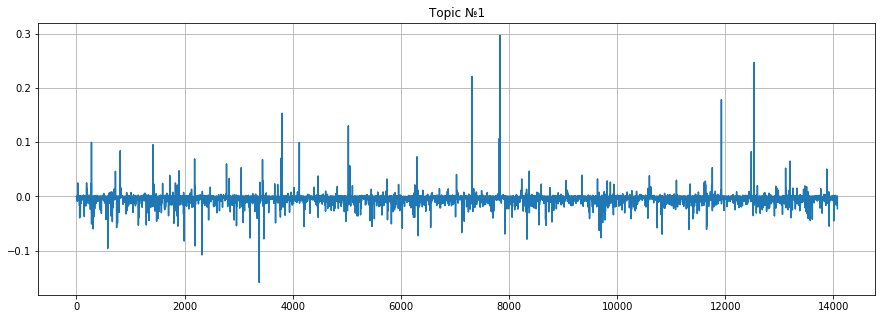

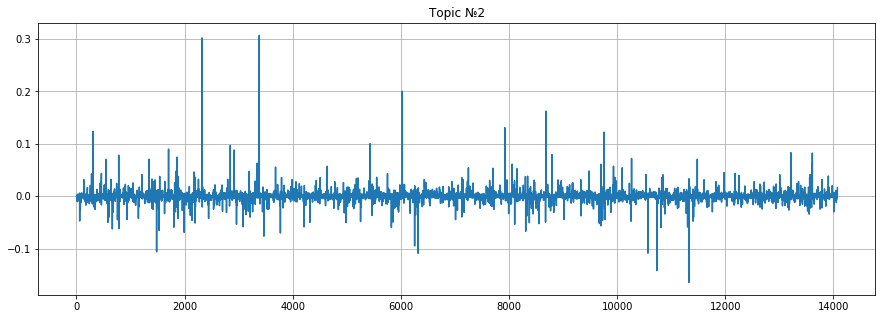

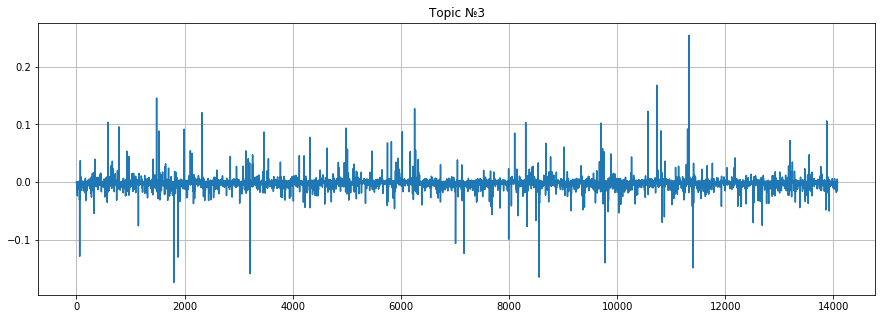

In [27]:
for i in range(N):
    plt.figure(figsize=(15, 5))
    plt.plot(svd.components_[i])
    plt.title("Topic №" + str(i))
    plt.grid(True)

# Corpora Latent Dirichlet Allocation

In [28]:
sentances = [[words[int(i)] for i in j.split(' ') if i != '' and words[int(i)] != "свой"] for j in texts.Text]
dictionary = corpora.Dictionary(sentances)
X_new = [dictionary.doc2bow(text) for text in sentances]

In [38]:
N = 6
lda_gensim = models.ldamodel.LdaModel(X_new, num_topics=N, id2word=dictionary, iterations=10)
pass

In [39]:
lda_gensim.print_topics()

[(0,
  '0.006*"россия" + 0.004*"сообщать" + 0.004*"президент" + 0.004*"фильм" + 0.003*"российский" + 0.003*"отмечать" + 0.003*"заявлять" + 0.003*"театр" + 0.003*"слово" + 0.003*"глава"'),
 (1,
  '0.008*"россия" + 0.005*"президент" + 0.003*"сообщать" + 0.003*"ученый" + 0.003*"российский" + 0.003*"кандидат" + 0.003*"фильм" + 0.003*"новый" + 0.003*"путин" + 0.003*"заявлять"'),
 (2,
  '0.008*"россия" + 0.005*"президент" + 0.004*"российский" + 0.004*"кандидат" + 0.003*"сообщать" + 0.003*"отмечать" + 0.003*"избирательный" + 0.003*"становиться" + 0.003*"партия" + 0.003*"глава"'),
 (3,
  '0.007*"россия" + 0.005*"российский" + 0.004*"президент" + 0.003*"сообщать" + 0.003*"отмечать" + 0.003*"ученый" + 0.003*"заявлять" + 0.003*"фильм" + 0.003*"кандидат" + 0.003*"самый"'),
 (4,
  '0.006*"россия" + 0.005*"российский" + 0.004*"президент" + 0.003*"ученый" + 0.003*"сообщать" + 0.003*"кандидат" + 0.003*"заявлять" + 0.003*"работа" + 0.003*"отмечать" + 0.003*"выборы"'),
 (5,
  '0.005*"россия" + 0.004*"пр

**Все полученные темы коррелируют с политикой и выборами.**

In [40]:
N = 1
lda_gensim = models.ldamodel.LdaModel(X_new, num_topics=N, id2word=dictionary, iterations=10)
pass

In [41]:
lda_gensim.print_topics()

[(0,
  '0.007*"россия" + 0.004*"президент" + 0.004*"российский" + 0.004*"сообщать" + 0.003*"ученый" + 0.003*"отмечать" + 0.003*"кандидат" + 0.003*"фильм" + 0.003*"заявлять" + 0.003*"становиться"')]

# Sklearn Latent Dirichlet Allocation

In [42]:
N = 13
lda_sklearn = LatentDirichletAllocation(n_components=N, max_iter=10, batch_size=10, evaluate_every=1, verbose=1, 
                                        n_jobs=4, learning_method='batch').fit(x)

iteration: 1 of max_iter: 10, perplexity: 1375439.3336
iteration: 2 of max_iter: 10, perplexity: 1006473.5904
iteration: 3 of max_iter: 10, perplexity: 743308.0135
iteration: 4 of max_iter: 10, perplexity: 556290.2140
iteration: 5 of max_iter: 10, perplexity: 433415.5651
iteration: 6 of max_iter: 10, perplexity: 363415.9019
iteration: 7 of max_iter: 10, perplexity: 324360.5158
iteration: 8 of max_iter: 10, perplexity: 303103.6847
iteration: 9 of max_iter: 10, perplexity: 289905.0602
iteration: 10 of max_iter: 10, perplexity: 281530.2380


In [44]:
lda_sklearn.components_.shape

(13, 14077)

In [49]:
for i in range(N):
    print("Topic №" + str(i)+": ")
    ind = np.argsort(lda_sklearn.components_[i])[-6:]
    metr = np.sort(lda_sklearn.components_[i])[-6:]
    for j in range(0, 6):
        print("\t" + words_sorted[ind][j] + " - " + str(metr[j]))

Topic №0: 
	доллар - 4.301563015648064
	банк - 4.485668515254177
	криптовалюта - 5.128572120837113
	ракета - 5.203179861347981
	рубль - 5.257654916118929
	спутник - 5.531763482242168
Topic №1: 
	каная - 0.5203766450871873
	алкоголь - 0.5348186828364485
	ожирение - 0.5469339857043054
	ипк - 0.5496436563922961
	ткань - 0.560301293837638
	невесомость - 0.7040501426635386
Topic №2: 
	вто - 1.1429584751247734
	вэб - 1.1806204614907225
	ямал - 1.1810619880230562
	квантовый - 1.2208387612481315
	поставка - 1.7502215346129584
	СПГ - 1.844987230599803
Topic №3: 
	сообщать - 11.981702234629797
	театр - 12.305453227316189
	президент - 13.502310485929382
	фильм - 13.784239853685031
	российский - 15.131147166562144
	россия - 20.512076792483963
Topic №4: 
	номинация - 1.9504133384559255
	хороший - 2.427920222456574
	награда - 2.877041632921896
	оскар - 3.014797436656512
	ведерников - 3.1244377044177294
	премия - 3.927363495022767
Topic №5: 
	зеркало - 0.5287667051849949
	иран - 0.5631666495546699
	к

**Полученные темы:**
    0. Валюта/Банки
    1. Наука.Медицина
    2. ...
    3. Путин на выборах
    4. Оскар
    5. ...
    6. Пенсия/Разорение банка Югра
    7. Искусство/Музыка
    8. ...
    9. ...
    10. Наука
    11. Деньги
    12. Выборы президента